In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder


In [3]:
# Load dataset
data = pd.read_csv("sri_lanka_flood_dataset_2016_2018.csv", encoding='latin1') 
print(data.head())

         Date District       City  Rainfall_(mm)  Min_Temp  Max_Temp  \
0  2016-01-01  Colombo    Colombo           6.22     24.11     29.31   
1  2016-01-01  Colombo   Nugegoda          14.53     20.95     30.53   
2  2016-01-01  Colombo   Dehiwala         110.36     21.13     34.25   
3  2016-01-01    Galle      Galle         150.43     23.47     28.56   
4  2016-01-01    Galle  Hikkaduwa          67.93     23.63     31.61   

   Elevation_(m)  Flood_Risk_Probability  
0             10                    0.02  
1             15                    0.05  
2             12                    0.36  
3             25                    0.49  
4             30                    0.22  


In [4]:
# dataset info
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19728 entries, 0 to 19727
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    19728 non-null  object 
 1   District                19728 non-null  object 
 2   City                    19728 non-null  object 
 3   Rainfall_(mm)           19728 non-null  float64
 4   Min_Temp                19728 non-null  float64
 5   Max_Temp                19728 non-null  float64
 6   Elevation_(m)           19728 non-null  int64  
 7   Flood_Risk_Probability  19728 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB
None


In [5]:
# Handle missing values
data.fillna(data.mean(numeric_only=True), inplace=True)

In [6]:
# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

In [7]:
# categorical columns 'District' and 'City' into numeric 
label_encoder_district = LabelEncoder()
data['District'] = label_encoder_district.fit_transform(data['District'])

label_encoder_city = LabelEncoder()
data['City'] = label_encoder_city.fit_transform(data['City'])

print(data.head())

        Date  District  City  Rainfall_(mm)  Min_Temp  Max_Temp  \
0 2016-01-01         0     1           6.22     24.11     29.31   
1 2016-01-01         0    12          14.53     20.95     30.53   
2 2016-01-01         0     2         110.36     21.13     34.25   
3 2016-01-01         1     4         150.43     23.47     28.56   
4 2016-01-01         1     6          67.93     23.63     31.61   

   Elevation_(m)  Flood_Risk_Probability  
0             10                    0.02  
1             15                    0.05  
2             12                    0.36  
3             25                    0.49  
4             30                    0.22  


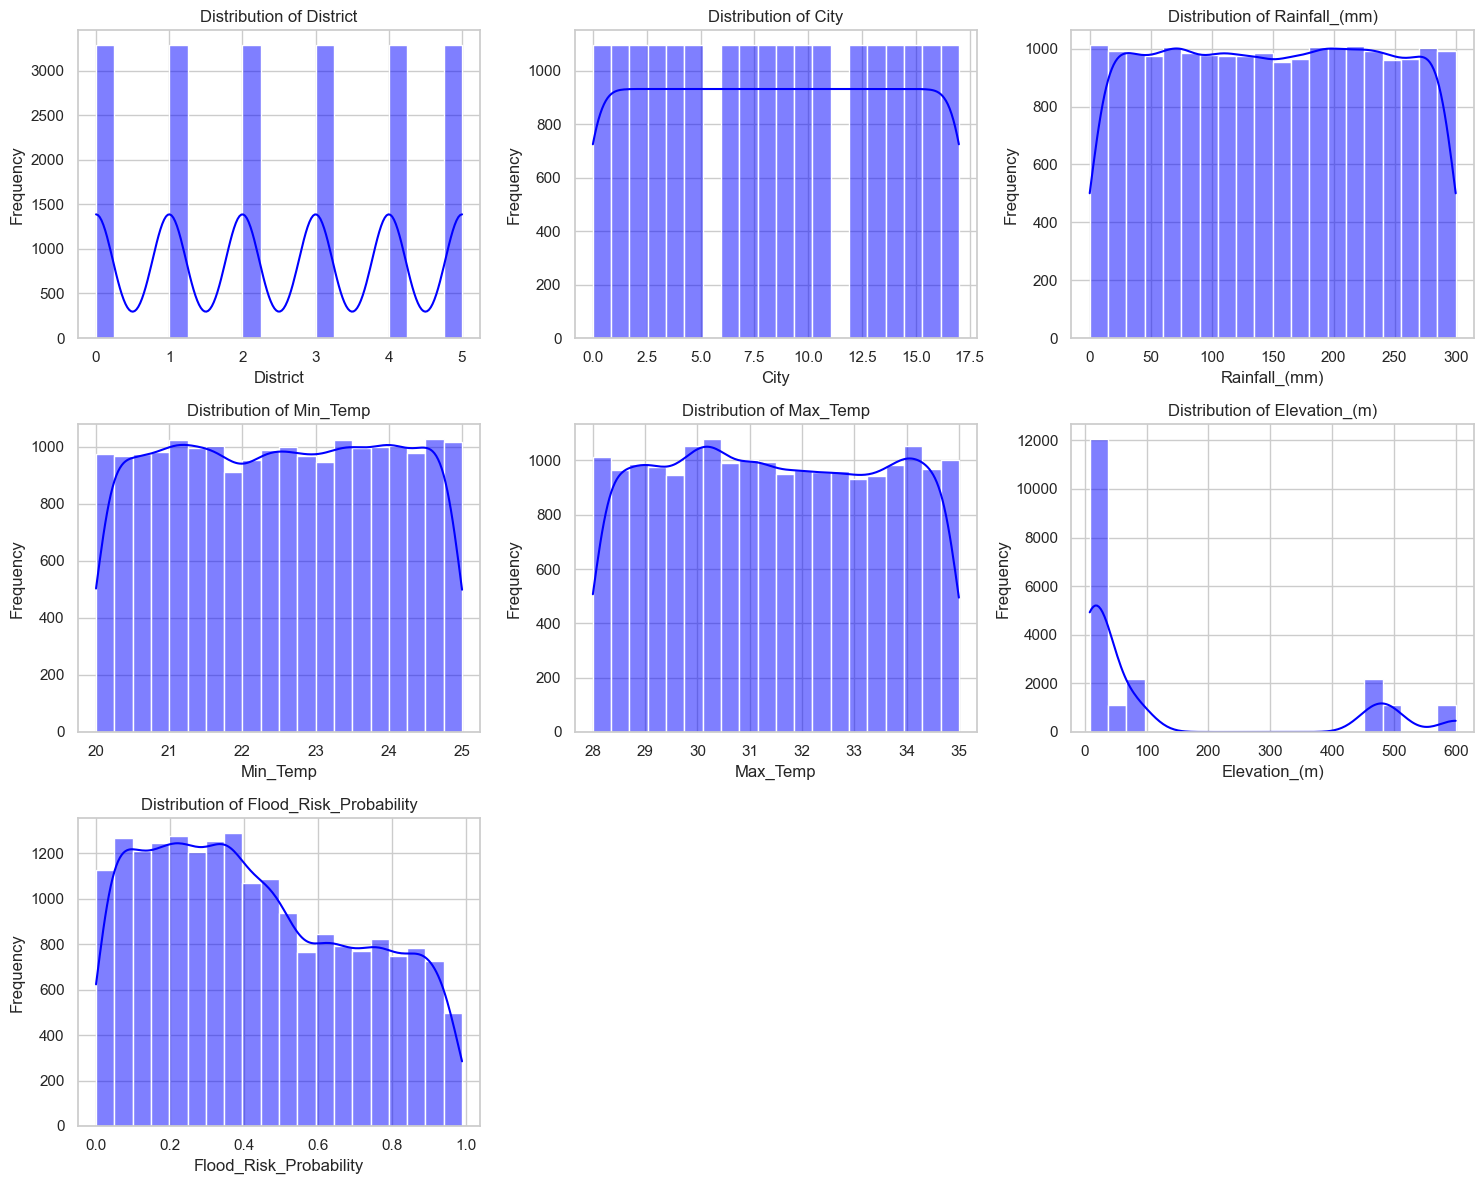

In [8]:
sns.set(style="whitegrid")

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

n_cols = 3
n_rows = int(np.ceil(len(numerical_columns) / n_cols))

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(data[col], kde=True, bins=20, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [9]:
# Features and target
X = data.drop(['Flood_Risk_Probability', 'Date', 'District', 'City'], axis=1)
y = data['Flood_Risk_Probability']

In [10]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Initialize and train the XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 9.600526268406593e-06
R^2 Score: 0.9998743924192992


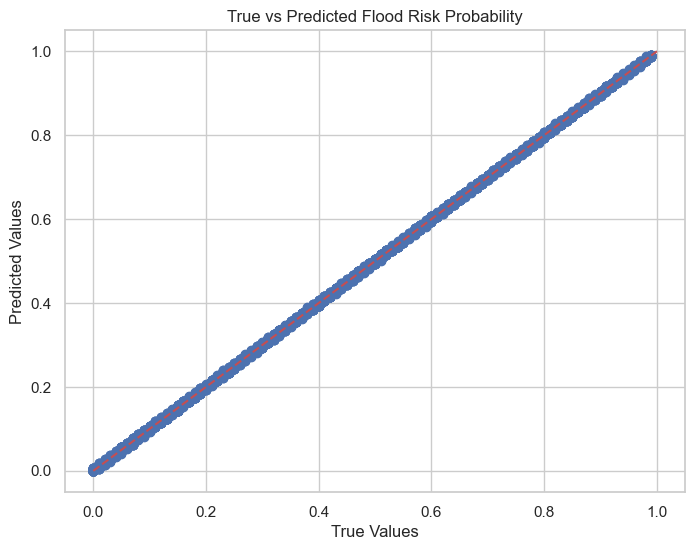

In [14]:
# Predict on the whole dataset
y_full_pred = model.predict(scaler.transform(X))

# Plot the true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_full_pred)
plt.plot([0, 1], [0, 1], '--r')
plt.title('True vs Predicted Flood Risk Probability')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [15]:
model_filename = 'flood_risk_model.joblib'
joblib.dump(model, model_filename)
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [16]:
# Load the model
model = joblib.load(model_filename)
scaler = joblib.load('scaler.joblib')

In [17]:
# New data for prediction
new_data = pd.DataFrame({
    'Rainfall_(mm)': [50.0],
    'Min_Temp': [22.5],
    'Max_Temp': [30.0],
    'Elevation_(m)': [200],
    'District': [label_encoder_district.transform(['Colombo'])[0]],
    'City': [label_encoder_city.transform(['Nugegoda'])[0]]
})

new_data = new_data.reindex(columns=X.columns, fill_value=0)

new_data_scaled = scaler.transform(new_data)

prediction = model.predict(new_data_scaled)

print(f"Predicted Flood Risk Probability: {prediction[0]}")


Predicted Flood Risk Probability: 0.14984814822673798


In [18]:
import joblib

joblib.dump(model, 'flood_risk_model_.joblib')
joblib.dump(scaler, 'scaler_.joblib')
joblib.dump(label_encoder_district, 'label_encoder_district_.pkl')
joblib.dump(label_encoder_city, 'label_encoder_city_.pkl')

['label_encoder_city_.pkl']